In [296]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [297]:
# Load PCA coordinates with metadata
coords_annot = pd.read_csv("../data/phage_PCA_coords_annot.tsv", sep="\t")
coords_annot

,Accession,PC1,PC2,Family,Species
0,AB334721,794.241276,-49.092602,Inoviridae,Inovirus M13
1,AB903967,-516.026653,157.874498,Herelleviridae,Kayvirus SA12
2,AB983711,429.152006,-290.099140,Autonotataviridae,Risjevirus RSJ5
3,AF063097,430.139756,224.574237,Peduoviridae,Peduovirus P2
4,AF115103,455.001581,226.285953,Aliceevansviridae,Moineauvirus Sfi21
...,...,...,...,...,...
836,PV660458,366.945155,-244.972051,Autoscriptoviridae,Escherichia phage LF82-23
837,PV683289,-929.176962,-136.877072,Straboviridae,Klebsiella phage HMGUkp1
838,PV775412,-533.718747,183.913713,Herelleviridae,Staphylococcus phage EMS22-2
839,PV786929,694.871194,77.156722,Casjensviridae,Proteus phage pPM01


### Static plot


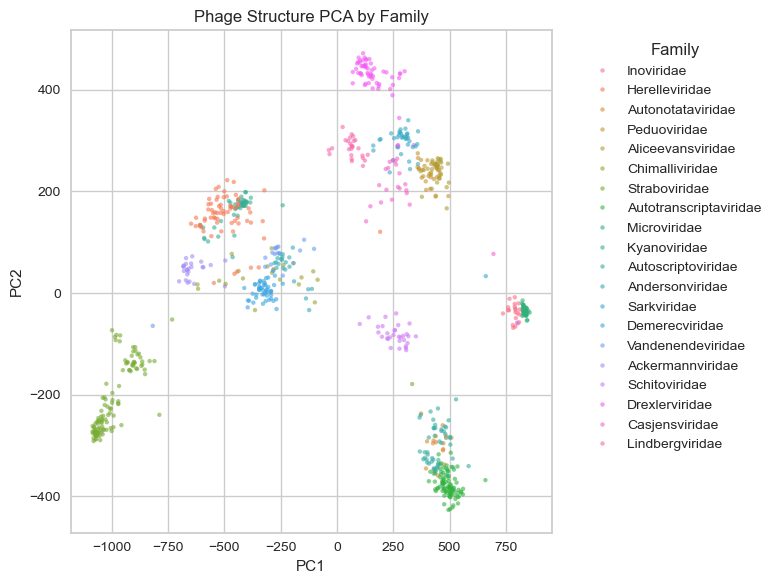

In [298]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=coords_annot,
    x="PC1",
    y="PC2",
    hue="Family",
    s=10,
    alpha=0.6,
    linewidth=0,
    legend="full",
)

plt.title("Phage Structure PCA by Family")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Family")
plt.tight_layout()
plt.show()

### Interactive Plot


In [299]:
fig = px.scatter(
    coords_annot,
    x="PC1",
    y="PC2",
    color="Family",
    hover_data=["Accession", "Species"],
    title="Structure-informed Phage Map",
)

fig.update_traces(marker=dict(size=5, opacity=0.7))
fig.update_layout(width=900, height=700, legend_title_text="Family")

# Show interactively in notebook
fig.show()

# Save to a standalone HTML
fig.write_html("../data/phage_PCA_interactive.html", include_plotlyjs="cdn")

# k-means Clustering


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import silhouette_visualizer
import numpy as np
from scipy.spatial import ConvexHull
import plotly.express as px
import plotly.graph_objects as go

Maximum score: n clusers = 11 , score: 0.6713303323852586


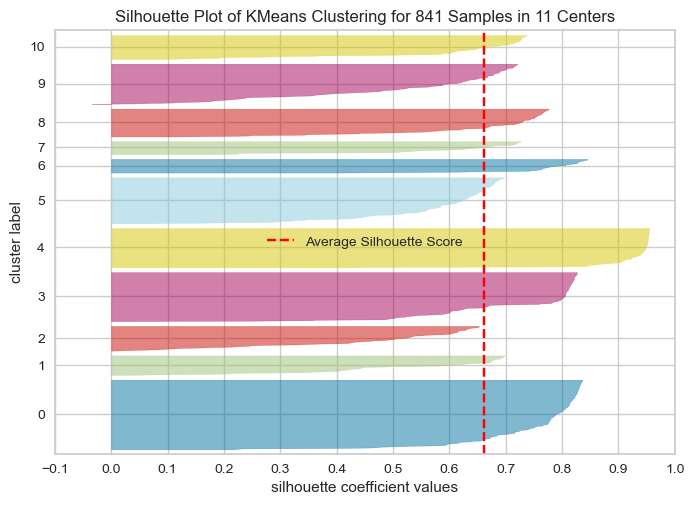

,estimator,KMeans(n_clus...andom_state=2)
,ax,<Axes: title=...luster label'>
,colors,'yellowbrick'
,is_fitted,'auto'
,n_clusters,np.int64(11)
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,2


In [301]:
# How many clusters?
X = coords_annot[["PC1", "PC2"]]

random_state = 2

results = [
    KMeans(i, random_state=random_state) for i in range(4, 25)
]  # Add 4 to results index to get n

scores = [silhouette_score(X, result.fit_predict(X)) for result in results]
best_n = (
    np.argmax(scores) + 7
)  # This should be "+ 4", but i like this clustering better (try it out)
print("Maximum score: n clusers =", best_n, ", score:", np.max(scores))

silhouette_visualizer(
    KMeans(best_n, random_state=random_state), X, colors="yellowbrick"
)

In [306]:
kmeans = KMeans(n_clusters=best_n, random_state=random_state).fit(
    coords_annot[["PC1", "PC2"]]
)
coords_annot["cluster"] = kmeans.labels_

coords_annot.to_csv("../data/phage_PCA_coords_annot.tsv", sep="\t", index=False)

In [303]:
# Draw base scatter plot
fig = px.scatter(
    coords_annot,
    x="PC1",
    y="PC2",
    color="Family",
    hover_data=["Accession", "Species"],
    title="Structure-informed Phage Map",
)

fig.update_traces(marker=dict(size=5, opacity=0.7))
fig.update_layout(width=900, height=700, legend_title_text="Family")

# Overlay convex hulls + cluster labels
colors = px.colors.qualitative.Vivid

for cluster_id in sorted(coords_annot["cluster"].unique()):
    cluster_points = coords_annot[coords_annot["cluster"] == cluster_id][
        ["PC1", "PC2"]
    ].values
    if len(cluster_points) < 3:
        continue  # need at least 3 points for a hull

    # Compute hull
    hull = ConvexHull(cluster_points)
    hull_pts = cluster_points[hull.vertices]
    hull_x = np.append(hull_pts[:, 0], hull_pts[0, 0])
    hull_y = np.append(hull_pts[:, 1], hull_pts[0, 1])

    # Draw cluster boundaries
    fig.add_trace(
        go.Scatter(
            x=hull_x,
            y=hull_y,
            mode="lines",
            line=dict(width=1.5, color=colors[cluster_id % len(colors)]),
            name=f"Cluster {cluster_id}",
            showlegend=False,
            opacity=0.4,
        )
    )

    # Draw cluster labels
    centroid = cluster_points.mean(axis=0)
    fig.add_trace(
        go.Scatter(
            x=[centroid[0]],
            y=[centroid[1]],
            mode="text",
            text=[str(cluster_id)],
            textposition="middle center",
            textfont=dict(size=16, color="black"),
            showlegend=False,
        )
    )

fig.show()